In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.ensemble import RandomForestClassifier

from sklearn.naive_bayes import BernoulliNB, GaussianNB

from scipy import stats
from scipy.stats import norm

import pickle #библиотека загрузки объектов в файл
from joblib import dump

## $\checkmark$ Общее описание проекта
|Признак|Описание|
|----:|:----|
|Home Ownership | домовладение |
|Annual Income | годовой доход |
|Years in current job | количество лет на текущем месте работы |
|Tax Liens | налоговые обременения |
|Number of Open Accounts | количество открытых счетов |
|Years of Credit History | количество лет кредитной истории |
|Maximum Open Credit | наибольший открытый кредит (максимальная сумма, которая когда-либо была доступна клиенту) |
|Number of Credit Problems | количество проблем с кредитом |
|Months since last delinquent | количество месяцев с последней просрочки платежа |
|Bankruptcies | банкротства |
|Purpose | цель кредита |
|Term | срок кредита |
|Current Loan Amount | текущая сумма кредита (сумма, которую еще предстоит выплатить клиенту)|
|Current Credit Balance | текущий кредитный баланс (сумма, которую может тратить клиент с кредитного счета)|
|Monthly Debt | ежемесячный долг|
|Credit Score | баллы кредитного рейтинга|
|Credit Default | факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)|

In [2]:
df = pd.read_csv("train.csv")
df.head(2)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [4]:
df.describe().round(1).T

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1366391.7,845339.2,164597.0,844341.0,1168386.0,1640137.0,1.014934e+07
Tax Liens,7500.0,0.0,0.3,0.0,0.0,0.0,0.0,7.000000e+00
Number of Open Accounts,7500.0,11.1,4.9,2.0,8.0,10.0,14.0,4.300000e+01
Years of Credit History,7500.0,18.3,7.0,4.0,13.5,17.0,21.8,5.770000e+01
Maximum Open Credit,7500.0,945153.7,16026216.7,0.0,279229.5,478159.0,793501.5,1.304726e+09
Number of Credit Problems,7500.0,0.2,0.5,0.0,0.0,0.0,0.0,7.000000e+00
Months since last delinquent,3419.0,34.7,21.7,0.0,16.0,32.0,50.0,1.180000e+02
Bankruptcies,7486.0,0.1,0.3,0.0,0.0,0.0,0.0,4.000000e+00
Current Loan Amount,7500.0,11873177.4,31926123.0,11242.0,180169.0,309573.0,519882.0,1.000000e+08
Current Credit Balance,7500.0,289833.2,317871.4,0.0,114256.5,209323.0,360406.2,6.506797e+06


## $\checkmark$ Создание вспомогательных функций

1. Функция для постоения гистограмм с основными статистическими данными

In [5]:
def destrib_fig(data, trait, n_bins=50, l_space_start=0, l_space_stop=0.5, l_space_count=10, dens=True):

    target_mean = round(data[trait].mean(), 2)
    target_median = data[trait].median()
    target_mode = data[trait].mode()[0]
    target_quant005 = data[trait].quantile(0.05)
    target_quant995 = data[trait].quantile(0.995)

    plt.figure(figsize = (13, 5))
    plt.hist(data[trait], density=dens, bins=n_bins, alpha=0.9, ec='Black',color = "navy" )

    y = np.linspace(l_space_start, l_space_stop, l_space_count)
    plt.plot([target_mean] * l_space_count, y, label='mean', linestyle='--', linewidth=2)
    plt.plot([target_median] * l_space_count, y, label='median', linestyle='--', linewidth=2)
    plt.plot([target_mode] * l_space_count, y, label='mode', linestyle='--', linewidth=2)
    plt.plot([target_quant005] * l_space_count, y, label='Quantile 0.05', linestyle='--',linewidth=2)
    plt.plot([target_quant995] * l_space_count, y, label='Quantile 0.995', linestyle='--',linewidth=2)
    plt.title(f'Гистограмма для переменной {trait}')
    plt.legend()
    plt.show()

2. Функция для постоения боксплота, гистограммы и плотности распределения

In [6]:
def plot_fig(data, trait, dens=True):
    
    fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))
    sns.boxplot(x = data[trait], data = data, orient = 'v', ax = ax1)
    ax1.set_title(f'Boxplot для переменной {trait}')
    ax1.tick_params(labelsize=15)

    sns.distplot(data[trait], ax = ax2)
    sns.despine(ax = ax2)
    ax2.set_title(f'Гистограмма для переменной {trait}')
    ax2.tick_params(labelsize=15)

    plt.subplots_adjust(wspace=0.5)
    plt.tight_layout() 

## $\checkmark$ Проверка на дублирующееся записи

In [7]:
print("Количество дублирубщихся данных  - {}".format(df.duplicated().sum()))

Количество дублирубщихся данных  - 0


## $\checkmark$ Переименование столбцов и категорий переменных

In [8]:
oh = {'Own Home': 'Собственный дом', 
     'Home Mortgage': "Дом в ипотеке", 
     'Rent': "Аренда" , 
     'Have Mortgage': "Ипотека"}
df= df.replace({"Home Ownership": oh})

In [9]:
pr = {"debt consolidation": "Консолидация долгов",
      'other': "Другой",
      'home improvements': "Ремонт дома",
      'take a trip' : "Путешествие",
      'buy a car': "Покупка машины",
      'small business': "Малый бизнес",
      'business loan': "Кредит на бизнес",
      'wedding': "Свадьба",
      'educational expenses': "Образование",
      'buy house': "Покупка дома",
      'medical bills':"Медицинские счета",
      'moving':"Передвижение",
      'major purchase':"Крупная покупка",
      'vacation':"Отпуск",
      'renewable energy':"Возобнавляемая энергия"}
df= df.replace({"Purpose":pr})

In [10]:
tm = {"Short Term":"Краткосрочный",
     'Long Term': "Долгосрочный"}
df= df.replace({"Term":tm})

In [11]:
df = df.rename(columns= {"Home Ownership" : "Домовладение", 
                         "Annual Income" : "Годовой доход" ,
                         "Years in current job" : "Количество лет на текущем месте работы" ,
                         "Tax Liens" : "Налоговые обременения" ,
                         "Number of Open Accounts" : "Количество открытых счетов" ,
                         "Years of Credit History" : "Количество лет кредитной истории" ,
                         "Maximum Open Credit" : "Максимальная сумма кредита" ,
                         "Number of Credit Problems" : "Количество проблем с кредитом" ,
                         "Months since last delinquent" : "Количество месяцев с последней просрочки платежа" ,
                         "Bankruptcies" : "Банкротство" ,
                         "Purpose" : "Цель кредита" ,
                         "Term" : "Срок кредита" ,
                         "Current Loan Amount" : "Текущая сумма кредита к погашению",
                         "Current Credit Balance" : "Текущий кредитный баланс",
                         "Monthly Debt" : "Ежемесячный долг",
                         "Credit Score" : "Баллы кредитного рейтинга",
                         "Credit Default" : "Кредитный дефолт"})

In [12]:
df.head(2)

,Домовладение,Годовой доход,Количество лет на текущем месте работы,Налоговые обременения,Количество открытых счетов,Количество лет кредитной истории,Максимальная сумма кредита,Количество проблем с кредитом,Количество месяцев с последней просрочки платежа,Банкротство,Цель кредита,Срок кредита,Текущая сумма кредита к погашению,Текущий кредитный баланс,Ежемесячный долг,Баллы кредитного рейтинга,Кредитный дефолт
0,Собственный дом,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,Консолидация долгов,Краткосрочный,99999999.0,47386.0,7914.0,749.0,0
1,Собственный дом,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,Консолидация долгов,Долгосрочный,264968.0,394972.0,18373.0,737.0,1


## $\checkmark$ Приведение данных к необходимым типам

In [13]:
df = df.astype({ "Количество проблем с кредитом": "Int64",
                "Банкротство": "Int64",
               "Количество открытых счетов": "Int64"})

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Домовладение                                      7500 non-null   object 
 1   Годовой доход                                     5943 non-null   float64
 2   Количество лет на текущем месте работы            7129 non-null   object 
 3   Налоговые обременения                             7500 non-null   float64
 4   Количество открытых счетов                        7500 non-null   Int64  
 5   Количество лет кредитной истории                  7500 non-null   float64
 6   Максимальная сумма кредита                        7500 non-null   float64
 7   Количество проблем с кредитом                     7500 non-null   Int64  
 8   Количество месяцев с последней просрочки платежа  3419 non-null   float64
 9   Банкротство        

## $\checkmark$ Работа с пропущенными значениями и выбросами

In [15]:
df.isnull().sum()

Домовладение                                           0
Годовой доход                                       1557
Количество лет на текущем месте работы               371
Налоговые обременения                                  0
Количество открытых счетов                             0
Количество лет кредитной истории                       0
Максимальная сумма кредита                             0
Количество проблем с кредитом                          0
Количество месяцев с последней просрочки платежа    4081
Банкротство                                           14
Цель кредита                                           0
Срок кредита                                           0
Текущая сумма кредита к погашению                      0
Текущий кредитный баланс                               0
Ежемесячный долг                                       0
Баллы кредитного рейтинга                           1557
Кредитный дефолт                                       0
dtype: int64

$\blacktriangleright$ **Столбец № 10. Заполнение пропущенного значения в столбце Банкротство**

In [16]:
df_b = df[df['Банкротство'].isnull()]
df_b

,Домовладение,Годовой доход,Количество лет на текущем месте работы,Налоговые обременения,Количество открытых счетов,Количество лет кредитной истории,Максимальная сумма кредита,Количество проблем с кредитом,Количество месяцев с последней просрочки платежа,Банкротство,Цель кредита,Срок кредита,Текущая сумма кредита к погашению,Текущий кредитный баланс,Ежемесячный долг,Баллы кредитного рейтинга,Кредитный дефолт
100,Собственный дом,337079.0,1 year,0.0,9,39.6,644204.0,0,0.0,<NA>,Образование,Краткосрочный,99999999.0,224770.0,4326.0,734.0,0
256,Аренда,857660.0,1 year,0.0,6,19.7,291082.0,0,0.0,<NA>,Консолидация долгов,Краткосрочный,99999999.0,236816.0,3488.0,743.0,0
257,Дом в ипотеке,NaN,2 years,0.0,15,13.6,1556390.0,0,0.0,<NA>,Консолидация долгов,Краткосрочный,447480.0,524210.0,19613.0,NaN,0
898,Аренда,739005.0,2 years,0.0,20,18.3,2177758.0,0,0.0,<NA>,Консолидация долгов,Краткосрочный,456808.0,607487.0,9669.0,732.0,1
1404,Аренда,349391.0,< 1 year,0.0,4,12.7,0.0,0,0.0,<NA>,Другой,Краткосрочный,11242.0,0.0,1243.0,747.0,0
3063,Аренда,464474.0,10+ years,0.0,5,14.9,38126.0,0,0.0,<NA>,Другой,Краткосрочный,44814.0,18373.0,929.0,7490.0,1
3252,Аренда,832770.0,< 1 year,0.0,7,16.5,636856.0,0,0.0,<NA>,Кредит на бизнес,Краткосрочный,156970.0,52250.0,1145.0,750.0,0
3351,Дом в ипотеке,2226192.0,8 years,0.0,14,23.3,792836.0,0,73.0,<NA>,Консолидация долгов,Краткосрочный,528968.0,625157.0,23746.0,674.0,0
3401,Аренда,326154.0,6 years,0.0,2,19.1,0.0,0,77.0,<NA>,Другой,Краткосрочный,99999999.0,0.0,1245.0,712.0,0
3496,Аренда,233567.0,1 year,0.0,7,11.7,0.0,0,0.0,<NA>,Образование,Краткосрочный,210166.0,0.0,0.0,746.0,0


Так, как в признаке Банкротство пропущено 14 единиц, данные пропуски  было решено исключить из датафрейма, т.к. корректно заполнить пропущенные данные не представляется возможным.

In [17]:
df = df.dropna(subset = ['Банкротство'])

In [18]:
print("Банкротство с пропущенными значениями равно:{}".format(df["Банкротство"].isna().sum()))

Банкротство с пропущенными значениями равно:0


$\blacktriangleright$ **Столбец № 2. Годовой доход**

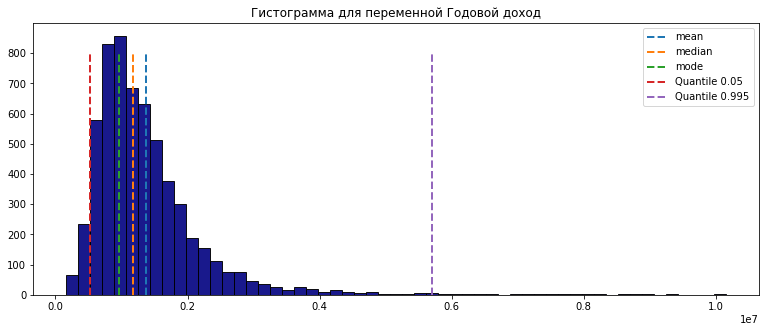

In [19]:
destrib_fig(df, 'Годовой доход', dens=False, n_bins=55, l_space_stop=800)

d:\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
d:\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


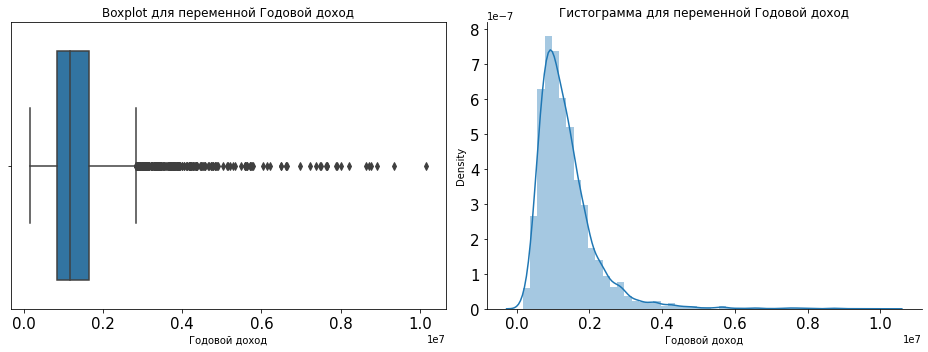

In [20]:
plot_fig(df, 'Годовой доход', dens=False)

Выдвинем гипотезу, что размер годового дохода зависит от количества проработанных лет

<AxesSubplot:xlabel='Количество лет на текущем месте работы'>

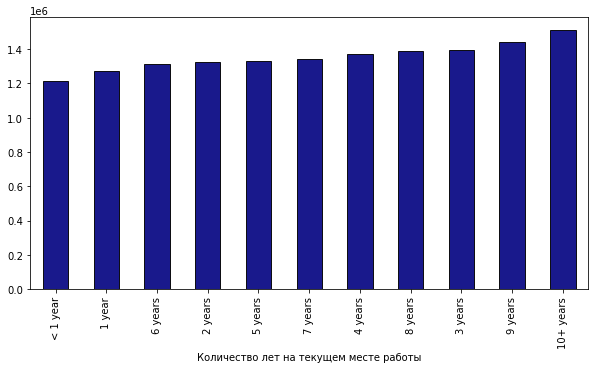

In [21]:
df_s = df.groupby(["Количество лет на текущем месте работы"])["Годовой доход"].mean().sort_values()
plt.figure(figsize = (10,5) )
df_s.plot.bar(edgecolor='k', color = "navy", alpha=0.9)

In [22]:
mask = df['Годовой доход'].isna()
df.loc[mask]

,Домовладение,Годовой доход,Количество лет на текущем месте работы,Налоговые обременения,Количество открытых счетов,Количество лет кредитной истории,Максимальная сумма кредита,Количество проблем с кредитом,Количество месяцев с последней просрочки платежа,Банкротство,Цель кредита,Срок кредита,Текущая сумма кредита к погашению,Текущий кредитный баланс,Ежемесячный долг,Баллы кредитного рейтинга,Кредитный дефолт
5,Аренда,NaN,7 years,0.0,12,14.6,366784.0,0,NaN,0,Другой,Долгосрочный,337304.0,165680.0,18692.0,NaN,1
8,Дом в ипотеке,NaN,5 years,0.0,17,15.7,0.0,1,NaN,1,Ремонт дома,Краткосрочный,129734.0,19.0,17.0,NaN,0
9,Дом в ипотеке,NaN,1 year,0.0,10,24.6,511302.0,0,6.0,0,Консолидация долгов,Долгосрочный,572880.0,205333.0,17613.0,NaN,1
10,Дом в ипотеке,NaN,< 1 year,0.0,7,11.5,256322.0,0,NaN,0,Консолидация долгов,Краткосрочный,220858.0,187492.0,14592.0,NaN,0
16,Аренда,NaN,7 years,0.0,6,17.8,899492.0,0,NaN,0,Консолидация долгов,Долгосрочный,313038.0,538346.0,18844.0,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7482,Дом в ипотеке,NaN,10+ years,0.0,14,30.5,645062.0,0,45.0,0,Консолидация долгов,Краткосрочный,188430.0,518662.0,23506.0,NaN,0
7492,Дом в ипотеке,NaN,10+ years,0.0,10,13.3,423984.0,0,NaN,0,Консолидация долгов,Краткосрочный,332948.0,161481.0,20966.0,NaN,0
7494,Собственный дом,NaN,< 1 year,0.0,7,8.2,301554.0,0,NaN,0,Консолидация долгов,Краткосрочный,290400.0,210938.0,5070.0,NaN,0
7498,Дом в ипотеке,NaN,NaN,0.0,21,26.5,1141250.0,0,NaN,0,Консолидация долгов,Краткосрочный,615274.0,476064.0,37118.0,NaN,0


In [23]:
yea_job = df['Количество лет на текущем месте работы'].unique()

for elem in yea_job:
    an_inc_year = df.loc[df['Количество лет на текущем месте работы'] == elem, 'Годовой доход'].median()
    df.loc[mask & (df['Количество лет на текущем месте работы']== elem), 'Годовой доход'] = an_inc_year

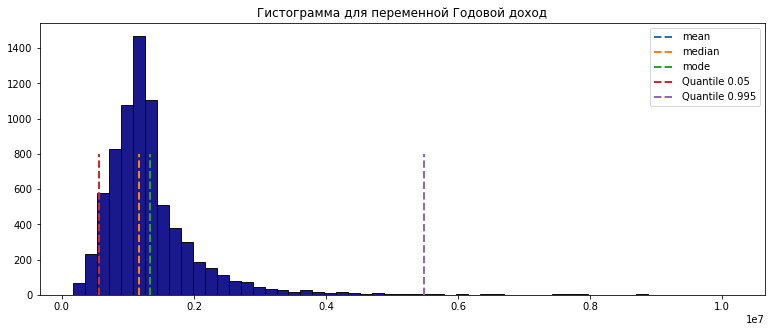

In [24]:
destrib_fig(df, 'Годовой доход', dens=False, n_bins=55, l_space_stop=800)

In [25]:
df_g = df[df['Годовой доход'].isnull()]
df_g

,Домовладение,Годовой доход,Количество лет на текущем месте работы,Налоговые обременения,Количество открытых счетов,Количество лет кредитной истории,Максимальная сумма кредита,Количество проблем с кредитом,Количество месяцев с последней просрочки платежа,Банкротство,Цель кредита,Срок кредита,Текущая сумма кредита к погашению,Текущий кредитный баланс,Ежемесячный долг,Баллы кредитного рейтинга,Кредитный дефолт
24,Собственный дом,NaN,NaN,0.0,12,25.0,1216336.0,0,61.0,0,Консолидация долгов,Краткосрочный,467676.0,818311.0,37530.0,NaN,0
144,Аренда,NaN,NaN,0.0,16,20.7,612216.0,0,42.0,0,Консолидация долгов,Долгосрочный,412852.0,378062.0,25810.0,NaN,1
368,Дом в ипотеке,NaN,NaN,0.0,7,16.4,1026124.0,1,NaN,1,Консолидация долгов,Краткосрочный,509036.0,458166.0,10121.0,NaN,0
424,Аренда,NaN,NaN,0.0,15,33.0,1027554.0,0,NaN,0,Ремонт дома,Краткосрочный,238106.0,151753.0,11183.0,NaN,0
667,Аренда,NaN,NaN,0.0,15,16.0,413820.0,0,NaN,0,Другой,Краткосрочный,222794.0,302366.0,18962.0,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6923,Аренда,NaN,NaN,0.0,10,26.5,262636.0,1,54.0,1,Консолидация долгов,Краткосрочный,93478.0,140866.0,5672.0,NaN,1
6989,Дом в ипотеке,NaN,NaN,0.0,11,26.1,1304930.0,0,NaN,0,Другой,Краткосрочный,193424.0,166801.0,8360.0,NaN,0
7074,Собственный дом,NaN,NaN,0.0,9,12.5,153142.0,0,44.0,0,Консолидация долгов,Краткосрочный,110506.0,98914.0,5512.0,NaN,0
7229,Собственный дом,NaN,NaN,0.0,21,34.0,2307338.0,0,36.0,0,Другой,Долгосрочный,370304.0,404529.0,28839.0,NaN,0


In [26]:
df = df.dropna(subset = ['Годовой доход'])
df = df.dropna(subset = ['Количество лет на текущем месте работы'])

In [27]:
df.isnull().sum()

Домовладение                                           0
Годовой доход                                          0
Количество лет на текущем месте работы                 0
Налоговые обременения                                  0
Количество открытых счетов                             0
Количество лет кредитной истории                       0
Максимальная сумма кредита                             0
Количество проблем с кредитом                          0
Количество месяцев с последней просрочки платежа    3886
Банкротство                                            0
Цель кредита                                           0
Срок кредита                                           0
Текущая сумма кредита к погашению                      0
Текущий кредитный баланс                               0
Ежемесячный долг                                       0
Баллы кредитного рейтинга                           1480
Кредитный дефолт                                       0
dtype: int64

$\blacktriangleright$ **Столбец № 9. Количество месяцев с последней просрочки платежа**

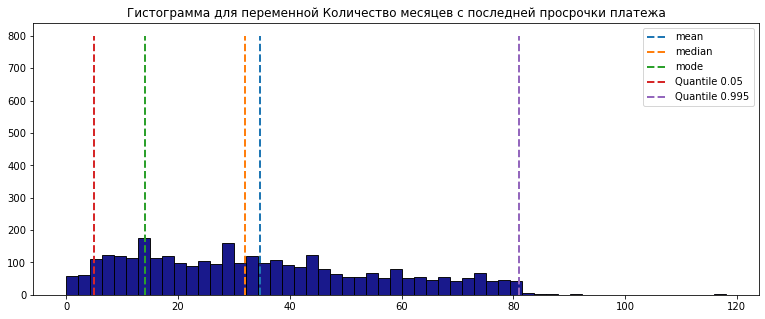

In [28]:
destrib_fig(df, 'Количество месяцев с последней просрочки платежа', dens=False, n_bins=55, l_space_stop=800)

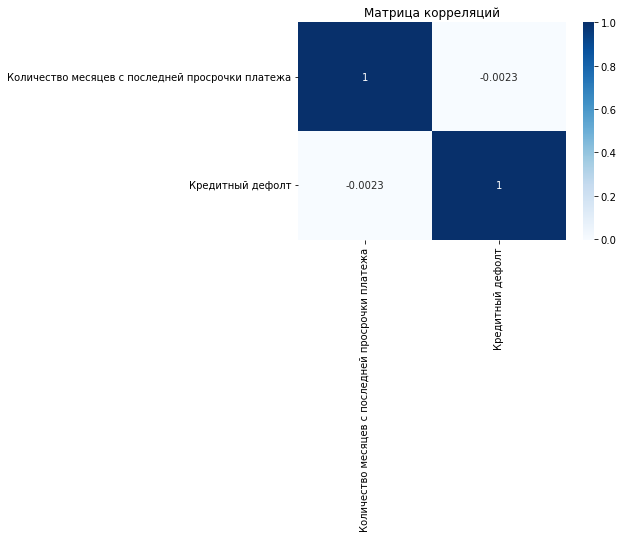

In [29]:
voz = df[["Количество месяцев с последней просрочки платежа", "Кредитный дефолт"]]
corr = voz.corr()
corr
sns.heatmap(corr, cmap="Blues", annot = True)
plt.title('Матрица корреляций')
plt.show()

т.к. показатель Количество месяцев с последней просрочки платежа не влияет на Кредитный дефолт и нет возможности корректно заполнить пропущенные значения, данный столбец подлежит удалению 

In [30]:
df = df.drop('Количество месяцев с последней просрочки платежа', axis=1)

$\blacktriangleright$ **Столбец № 16. Баллы кредитного рейтинга**

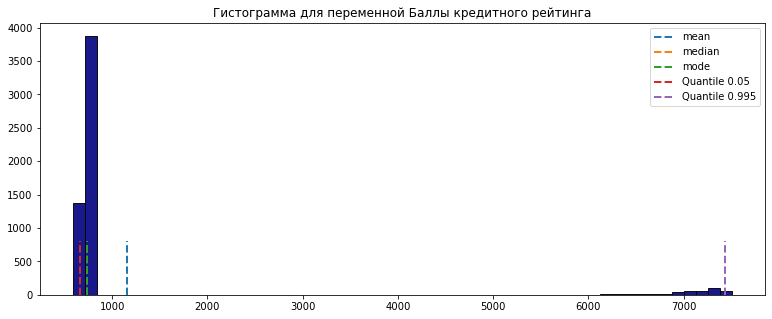

In [31]:
destrib_fig(df, 'Баллы кредитного рейтинга', dens=False, n_bins=55, l_space_stop=800)

d:\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
d:\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


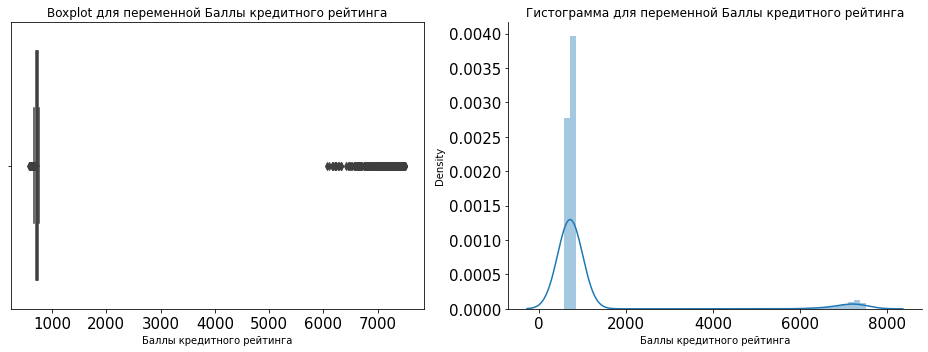

In [32]:
plot_fig(df, 'Баллы кредитного рейтинга', dens=False)

In [33]:
credit_score_mode = df['Баллы кредитного рейтинга'].mode().tolist()
df['Баллы кредитного рейтинга'].fillna(credit_score_mode[0], inplace=True)

In [34]:
df = df[df["Баллы кредитного рейтинга"] < 5000]

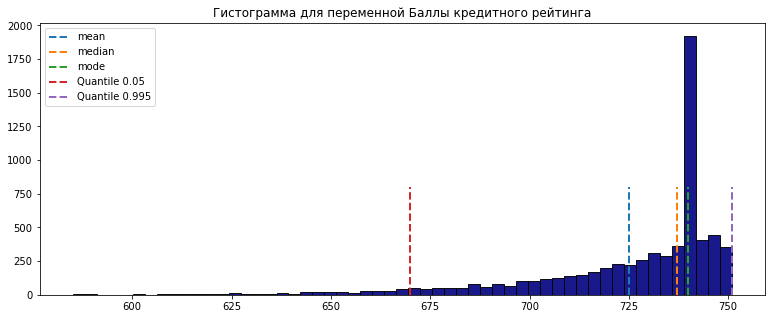

In [35]:
destrib_fig(df, 'Баллы кредитного рейтинга', dens=False, n_bins=55, l_space_stop=800)

**7. Максимальная сумма кредита**

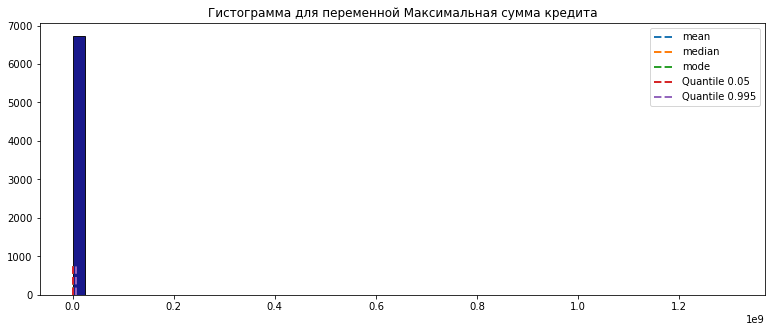

In [36]:
destrib_fig(df, 'Максимальная сумма кредита', dens=False, n_bins=55, l_space_stop=800)

d:\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
d:\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


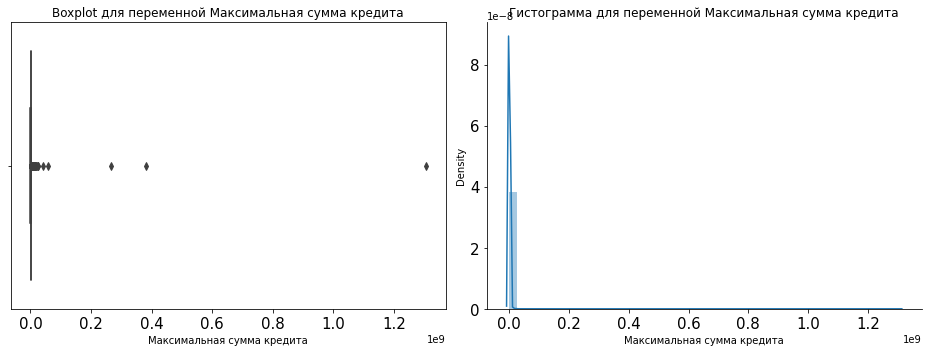

In [37]:
plot_fig(df, 'Максимальная сумма кредита', dens=False)

In [38]:
df["Максимальная сумма кредита"].quantile([0, 0.05, 0.995, 1])

0.000    0.000000e+00
0.050    1.103905e+05
0.995    6.248933e+06
1.000    1.304726e+09
Name: Максимальная сумма кредита, dtype: float64

In [39]:
df = df[df["Максимальная сумма кредита"] < 10000000]

d:\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
d:\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


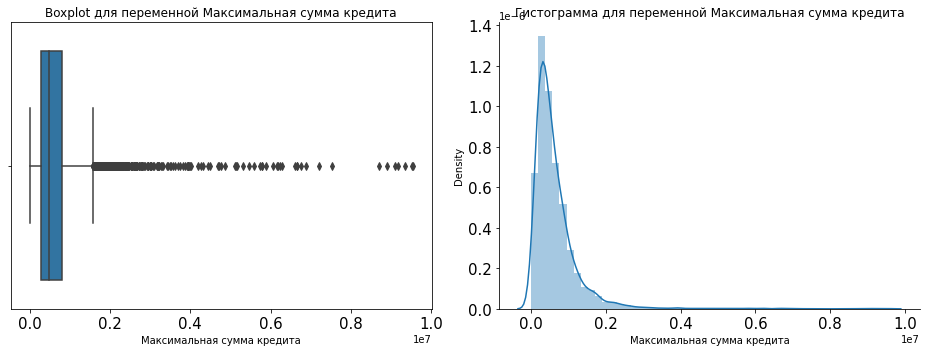

In [40]:
plot_fig(df, 'Максимальная сумма кредита', dens=False)

**13. Текущая сумма кредита к погашению**

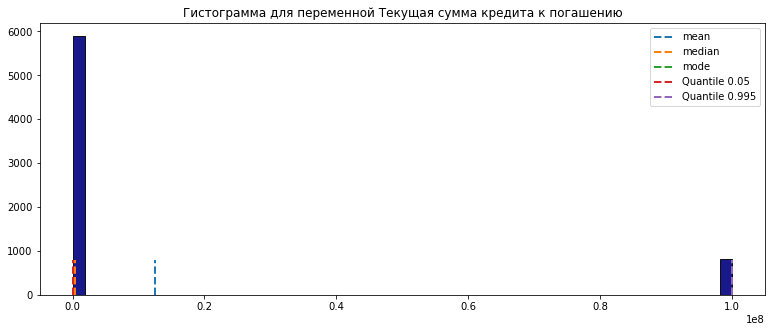

In [41]:
destrib_fig(df, 'Текущая сумма кредита к погашению', dens=False, n_bins=55, l_space_stop=800)

d:\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
d:\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


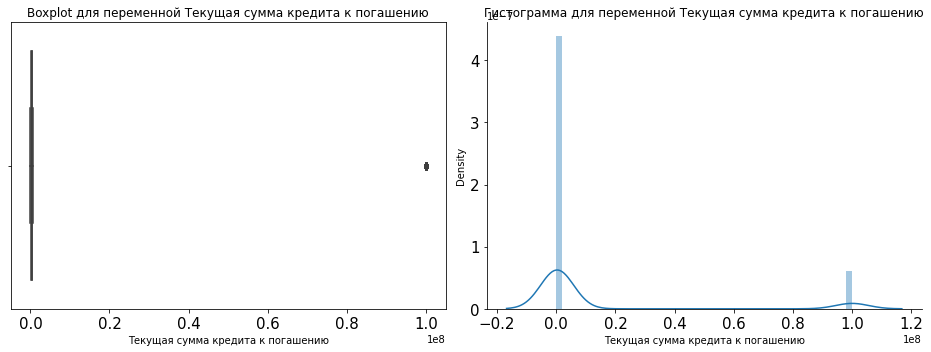

In [42]:
plot_fig(df, 'Текущая сумма кредита к погашению', dens=False)

In [43]:
df = df[df["Текущая сумма кредита к погашению"]< 99999999.0]

d:\anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
d:\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


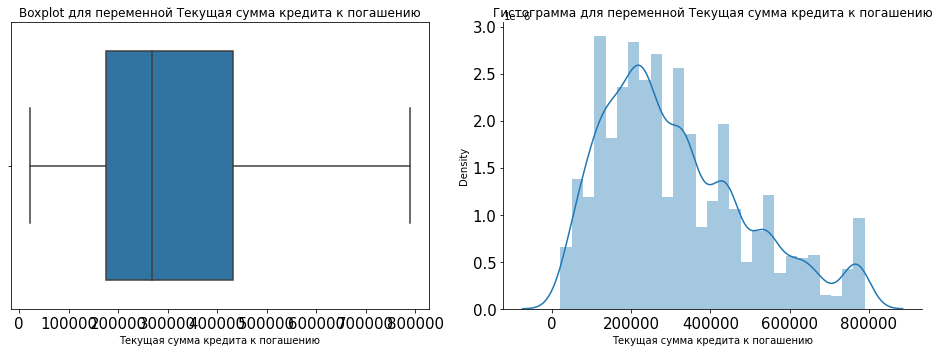

In [44]:
plot_fig(df,'Текущая сумма кредита к погашению', dens=False)

**14. Текущий кредитный баланс**

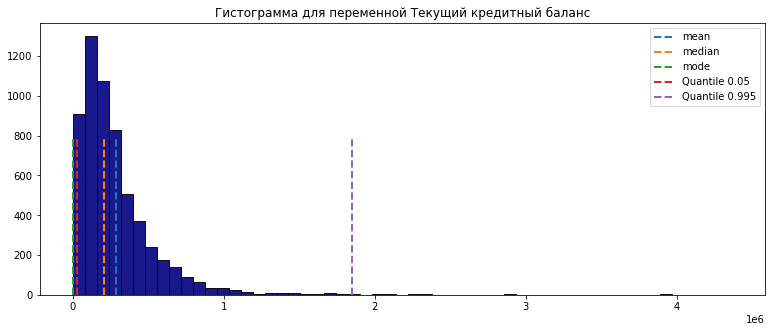

In [45]:
destrib_fig(df, 'Текущий кредитный баланс', dens=False, n_bins=55, l_space_stop=800)

In [46]:
df["Текущий кредитный баланс"].quantile([0, 0.05, 0.995, 1])

0.000          0.00
0.050      28697.60
0.995    1850076.36
1.000    4367245.00
Name: Текущий кредитный баланс, dtype: float64

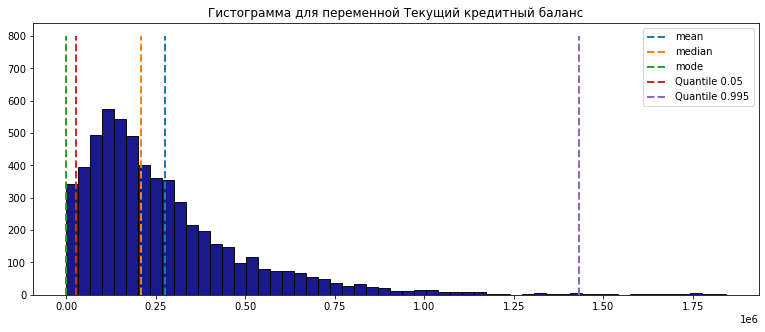

In [47]:
df = df[df["Текущий кредитный баланс"]< 1850076.36]
destrib_fig(df, 'Текущий кредитный баланс', dens=False, n_bins=55, l_space_stop=800)

**15. Ежемесячный долг**

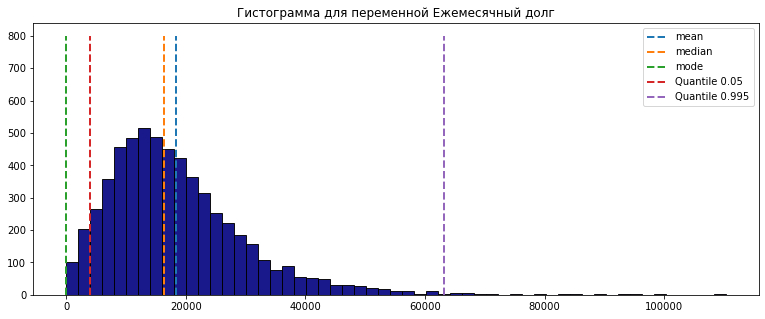

In [48]:
destrib_fig(df, 'Ежемесячный долг', dens=False, n_bins=55, l_space_stop=800)

In [49]:
df.isnull().sum()

Домовладение                              0
Годовой доход                             0
Количество лет на текущем месте работы    0
Налоговые обременения                     0
Количество открытых счетов                0
Количество лет кредитной истории          0
Максимальная сумма кредита                0
Количество проблем с кредитом             0
Банкротство                               0
Цель кредита                              0
Срок кредита                              0
Текущая сумма кредита к погашению         0
Текущий кредитный баланс                  0
Ежемесячный долг                          0
Баллы кредитного рейтинга                 0
Кредитный дефолт                          0
dtype: int64

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5867 entries, 1 to 7499
Data columns (total 16 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Домовладение                            5867 non-null   object 
 1   Годовой доход                           5867 non-null   float64
 2   Количество лет на текущем месте работы  5867 non-null   object 
 3   Налоговые обременения                   5867 non-null   float64
 4   Количество открытых счетов              5867 non-null   Int64  
 5   Количество лет кредитной истории        5867 non-null   float64
 6   Максимальная сумма кредита              5867 non-null   float64
 7   Количество проблем с кредитом           5867 non-null   Int64  
 8   Банкротство                             5867 non-null   Int64  
 9   Цель кредита                            5867 non-null   object 
 10  Срок кредита                            5867 non-null   obje

## $\checkmark$ EDA анализ

In [51]:
df.describe().round(1)

,Годовой доход,Налоговые обременения,Количество открытых счетов,Количество лет кредитной истории,Максимальная сумма кредита,Количество проблем с кредитом,Банкротство,Текущая сумма кредита к погашению,Текущий кредитный баланс,Ежемесячный долг,Баллы кредитного рейтинга,Кредитный дефолт
count,5867.0,5867.0,5867.0,5867.0,5867.0,5867.0,5867.0,5867.0,5867.0,5867.0,5867.0,5867.0
mean,1330005.9,0.0,11.1,18.0,616645.0,0.2,0.1,310568.6,274386.4,18417.8,724.2,0.3
std,725024.3,0.3,4.9,6.7,564061.0,0.5,0.3,180741.6,240629.0,11576.5,26.0,0.4
min,164597.0,0.0,2.0,4.0,0.0,0.0,0.0,21472.0,0.0,0.0,585.0,0.0
25%,962872.5,0.0,8.0,13.5,277189.0,0.0,0.0,174691.0,114294.5,10370.0,715.0,0.0
50%,1163968.5,0.0,10.0,16.9,473352.0,0.0,0.0,267476.0,208658.0,16355.0,737.0,0.0
75%,1468519.5,0.0,14.0,21.5,783805.0,0.0,0.0,430628.0,357190.5,23922.5,740.0,1.0
max,10149344.0,7.0,43.0,51.0,9339924.0,7.0,4.0,789030.0,1842449.0,110311.0,751.0,1.0


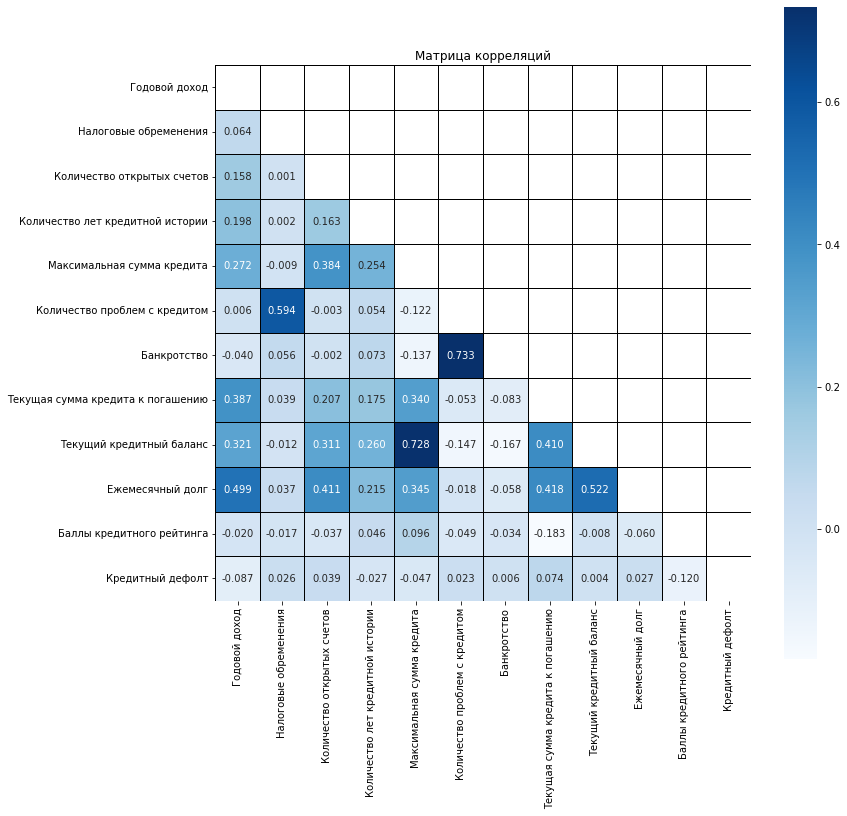

In [52]:
fig, ax = plt.subplots(figsize=(12,12))
ax = sns.heatmap(data = df.corr(), annot=True, square=True, 
            cmap='Blues', fmt='.3f', linewidths=1, linecolor='black', mask=np.triu(df.corr()))
plt.title('Матрица корреляций')
plt.show()

Text(0, 0.5, 'Ежемесячный долг')

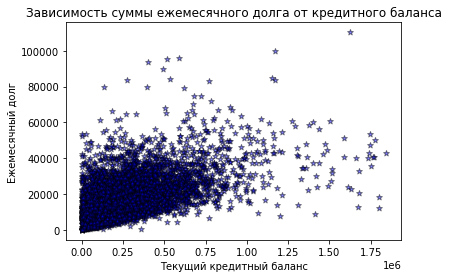

In [53]:
plt.scatter(x = df["Текущий кредитный баланс"], y = df["Ежемесячный долг"], marker = "*", edgecolor = "black", color = "blue", alpha = 0.5)
plt.title("Зависимость суммы ежемесячного долга от кредитного баланса")
plt.xlabel("Текущий кредитный баланс")
plt.ylabel("Ежемесячный долг")

Text(0, 0.5, 'Максимальная сумма кредита')

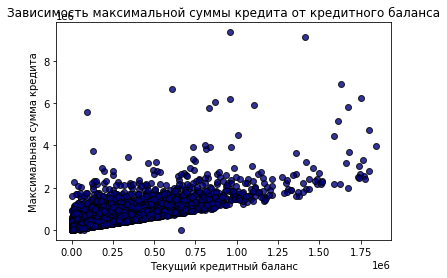

In [54]:
plt.scatter(x = df["Текущий кредитный баланс"], y = df["Максимальная сумма кредита"], marker = "o", edgecolor = "black", color = "navy", alpha = 0.8)
plt.title("Зависимость максимальной суммы кредита от кредитного баланса")
plt.xlabel("Текущий кредитный баланс")
plt.ylabel("Максимальная сумма кредита")

Text(0, 0.5, 'Годовой доход')

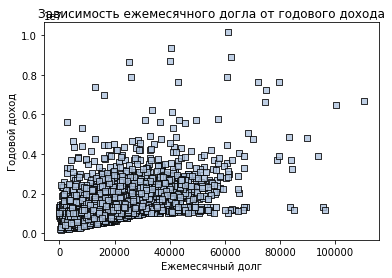

In [55]:
plt.scatter(x = df["Ежемесячный долг"], y = df["Годовой доход"], marker = "s", edgecolor = "black", color = "lightsteelblue", alpha = 0.8)
plt.title("Зависимость ежемесячного догла от годового дохода")
plt.xlabel("Ежемесячный долг")
plt.ylabel("Годовой доход")

In [56]:
df.head(2)

,Домовладение,Годовой доход,Количество лет на текущем месте работы,Налоговые обременения,Количество открытых счетов,Количество лет кредитной истории,Максимальная сумма кредита,Количество проблем с кредитом,Банкротство,Цель кредита,Срок кредита,Текущая сумма кредита к погашению,Текущий кредитный баланс,Ежемесячный долг,Баллы кредитного рейтинга,Кредитный дефолт
1,Собственный дом,1025487.0,10+ years,0.0,15,15.3,1181730.0,0,0,Консолидация долгов,Долгосрочный,264968.0,394972.0,18373.0,737.0,1
3,Собственный дом,805068.0,6 years,0.0,8,22.5,147400.0,1,1,Консолидация долгов,Краткосрочный,121396.0,95855.0,11338.0,694.0,0


In [57]:
int_var = ["Годовой доход", "Ежемесячный долг", "Текущая сумма кредита к погашению", "Текущий кредитный баланс"]
int_var2 = ["Количество открытых счетов", "Количество лет кредитной истории", "Максимальная сумма кредита", "Баллы кредитного рейтинга"]

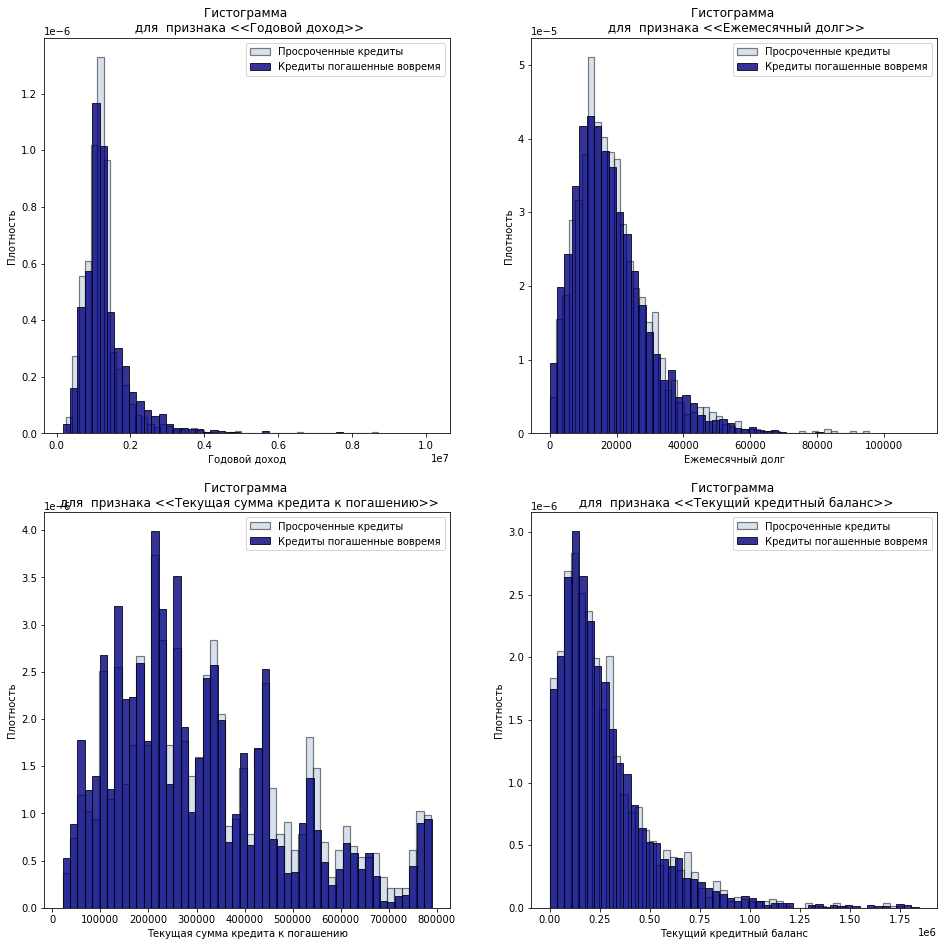

In [58]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(16,16))
i = 0
l = 0
j = 0
for i in range(2):
    for j in range(2):
        axes[i, j].hist(df[df["Кредитный дефолт"] == 1][int_var[l]], 
                        bins = 50, density=True, color = "lightsteelblue", edgecolor='black', linewidth=1.2, 
                        alpha = 0.5, histtype = 'barstacked', label = 'Просроченные кредиты')
        axes[i, j].hist(df[df["Кредитный дефолт"] == 0 ][int_var[l]], 
                        bins = 50, density=True,  color = "navy", edgecolor='black', linewidth=1, 
                        alpha = 0.8, histtype = 'barstacked', label = 'Кредиты погашенные вовремя')
        axes[i, j].set_title("Гистограмма \n для  признака <<{}>>".format(int_var[l]))
        axes[i, j].set_xlabel(int_var[l])
        axes[i, j].set_ylabel('Плотность')
        axes[i, j].legend()
        l+=1

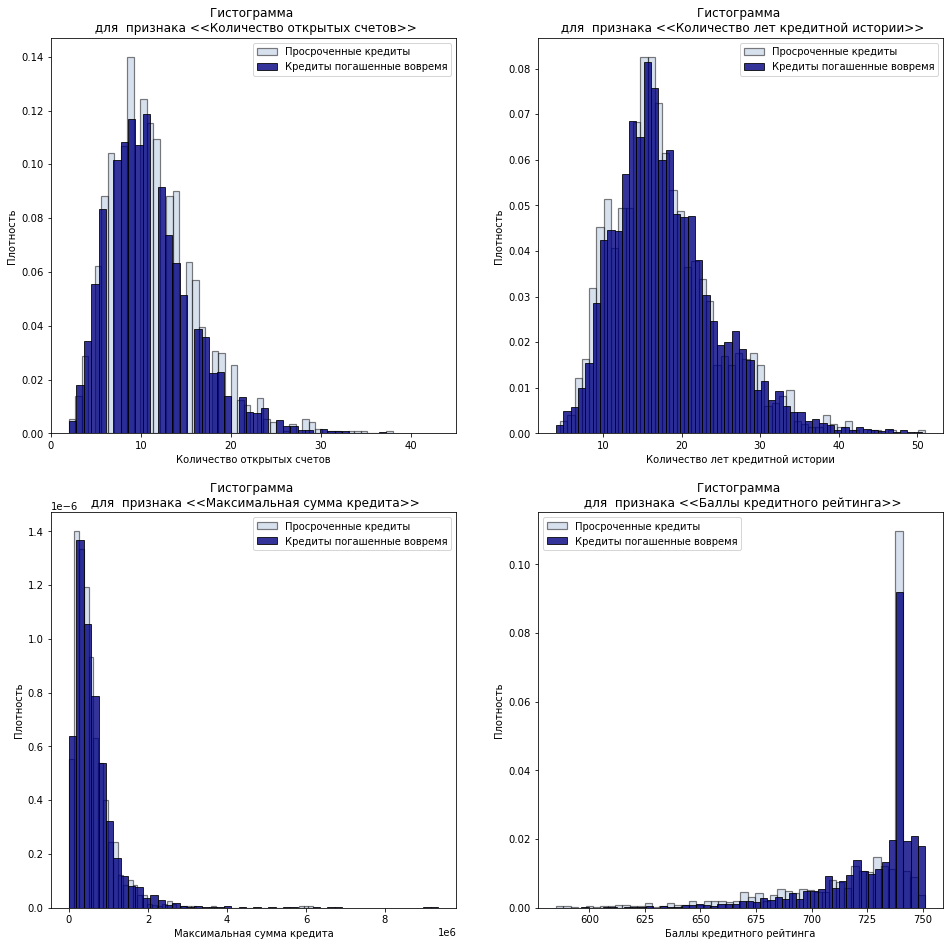

In [59]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(16,16))
i = 0
l = 0
j = 0
for i in range(2):
    for j in range(2):
        axes[i, j].hist(df[df["Кредитный дефолт"] == 1][int_var2[l]], 
                        bins = 50, density=True, color = "lightsteelblue", edgecolor='black', linewidth=1.2, 
                        alpha = 0.5, histtype = 'barstacked', label = 'Просроченные кредиты')
        axes[i, j].hist(df[df["Кредитный дефолт"] == 0 ][int_var2[l]], 
                        bins = 50, density=True,  color = "navy", edgecolor='black', linewidth=1, 
                        alpha = 0.8, histtype = 'barstacked', label = 'Кредиты погашенные вовремя')
        axes[i, j].set_title("Гистограмма \n для  признака <<{}>>".format(int_var2[l]))
        axes[i, j].set_xlabel(int_var2[l])
        axes[i, j].set_ylabel('Плотность')
        axes[i, j].legend()
        l+=1

,index,Цель кредита
0,Консолидация долгов,4672
1,Другой,514
2,Ремонт дома,306
3,Кредит на бизнес,103
4,Покупка машины,75
5,Медицинские счета,57
6,Крупная покупка,33
7,Путешествие,30
8,Покупка дома,26
9,Малый бизнес,19


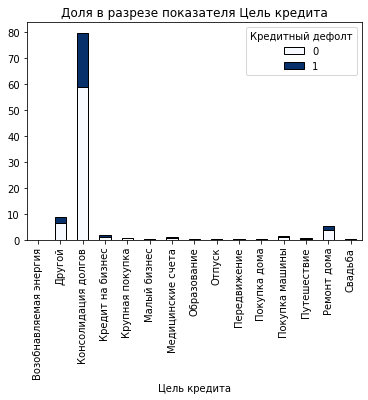

In [60]:
df_ctatu2 = pd.crosstab(df["Цель кредита"], df["Кредитный дефолт"])/len(df["Цель кредита"])*100
df_ctatu2.plot.bar(stacked = True, cmap="Blues", edgecolor='black')
plt.title("Доля в разрезе показателя Цель кредита")

count_ctatu2= df.groupby('Цель кредита', as_index=False).count().sort_values(by='Цель кредита', ascending=False)
count_ctatu2= df['Цель кредита'].value_counts().reset_index()
count_ctatu2

,index,Количество лет на текущем месте работы
0,10+ years,1922
1,2 years,580
2,3 years,517
3,< 1 year,460
4,5 years,441
5,1 year,402
6,4 years,393
7,6 years,333
8,7 years,328
9,8 years,273


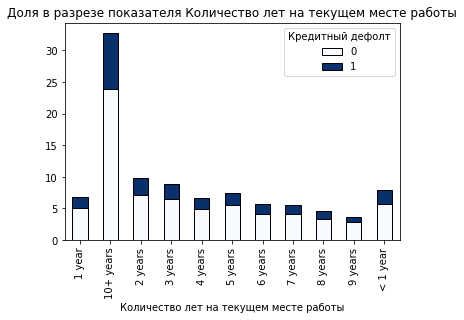

In [61]:
df_ctatu3 = pd.crosstab(df["Количество лет на текущем месте работы"], df["Кредитный дефолт"])/len(df["Цель кредита"])*100
df_ctatu3.plot.bar(stacked = True, cmap="Blues", edgecolor='black')
plt.title("Доля в разрезе показателя Количество лет на текущем месте работы")

count_ctatu3= df.groupby('Количество лет на текущем месте работы', as_index=False).count().sort_values(by='Количество лет на текущем месте работы', ascending=False)
count_ctatu3= df['Количество лет на текущем месте работы'].value_counts().reset_index()
count_ctatu3

,index,Срок кредита
0,Краткосрочный,4281
1,Долгосрочный,1586


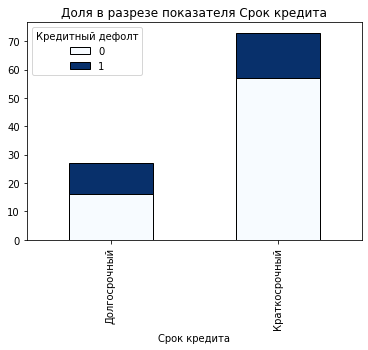

In [62]:
df_ctatu4 = pd.crosstab(df["Срок кредита"], df["Кредитный дефолт"])/len(df["Цель кредита"])*100
df_ctatu4.plot.bar(stacked = True, cmap="Blues", edgecolor='black')
plt.title("Доля в разрезе показателя Срок кредита")

count_ctatu4= df.groupby('Срок кредита', as_index=False).count().sort_values(by='Срок кредита', ascending=False)
count_ctatu4= df['Срок кредита'].value_counts().reset_index()
count_ctatu4

,index,Домовладение
0,Дом в ипотеке,2846
1,Аренда,2541
2,Собственный дом,470
3,Ипотека,10


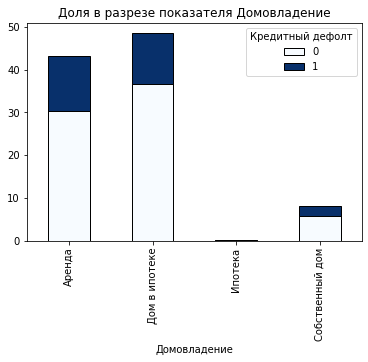

In [63]:
df_ctatu5 = pd.crosstab(df["Домовладение"], df["Кредитный дефолт"])/len(df["Цель кредита"])*100
df_ctatu5.plot.bar(stacked = True, cmap="Blues", edgecolor='black')
plt.title("Доля в разрезе показателя Домовладение")

count_ctatu5= df.groupby('Домовладение', as_index=False).count().sort_values(by='Домовладение', ascending=False)
count_ctatu5= df['Домовладение'].value_counts().reset_index()
count_ctatu5


## $\checkmark$ Построение моделей

$\blacktriangleright$ **Подготовка данных**

**1. Кодировка текстовых данных с помощью LabelEncoder**

In [64]:
f_log = df.copy()

In [65]:
def encode (df):
    
    for column in df.columns: #перебор имен столбцов
        if df[column].dtype != 'int64' or df[column].dtype != 'float64' : #проверяем тип данных в столбце
            trans_data = LabelEncoder() #создаем объект кодирования, переменная, благодаря которой будем кодировать данные
            trans_data.fit(df[column]) #Обучение
            df[column] = trans_data.transform(df[column]) #трансформируем исходные данные и сохраняем в соответствующий столбец DataFrame
            
    return df

In [66]:
encode(f_log)
f_log.head(2)

,Домовладение,Годовой доход,Количество лет на текущем месте работы,Налоговые обременения,Количество открытых счетов,Количество лет кредитной истории,Максимальная сумма кредита,Количество проблем с кредитом,Банкротство,Цель кредита,Срок кредита,Текущая сумма кредита к погашению,Текущий кредитный баланс,Ежемесячный долг,Баллы кредитного рейтинга,Кредитный дефолт
1,3,1565,1,0,13,108,4921,0,0,2,0,2286,4064,3029,140,1
3,3,862,6,0,6,180,417,1,1,2,1,649,998,1551,97,0


**2. Нормализация данных**

In [67]:
def normalize(df, data_columns): #функция для нормализации
    scaler = MinMaxScaler()#создаем переменную, храняющую метод нормализации (объект)
    for column in data_columns:
        scaler.fit(df[column]) #нормализуем
        df[column] = scaler.transform(df[column]) #трансформируем к нормализованным данным
    return df

In [68]:
f_log = normalize(f_log, [['Годовой доход', 'Налоговые обременения', 'Количество открытых счетов', 'Количество лет кредитной истории', 'Максимальная сумма кредита', 'Количество проблем с кредитом', 'Текущая сумма кредита к погашению','Текущий кредитный баланс', 'Ежемесячный долг','Баллы кредитного рейтинга' ]])

**3. Балансировка**

Процент погашенных 72.93335605931482
Процент просроченных 27.066643940685186


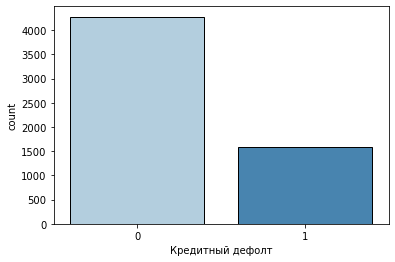

In [69]:
sns.countplot(x = "Кредитный дефолт", data = f_log, palette = "Blues", ec='Black')
count_no_sub = len(f_log[f_log['Кредитный дефолт']==0]) 
count_sub = len(f_log[f_log['Кредитный дефолт']==1]) 
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub) 
print("Процент погашенных", pct_of_no_sub*100) 
pct_of_sub = count_sub/(count_no_sub+count_sub) 
print("Процент просроченных", pct_of_sub*100)

Применяем метод sample для балансировки, чтобы при обучении модель не переобучилась

In [70]:
num_0 = f_log["Кредитный дефолт"].value_counts()[0] 
num_1 = f_log["Кредитный дефолт"].value_counts()[1] 
df_new = pd.concat([f_log[f_log["Кредитный дефолт"]==0].sample(num_1, random_state = 1), f_log[f_log["Кредитный дефолт"]==1]])
print(df_new['Кредитный дефолт'].value_counts(dropna=False))

0    1588
1    1588
Name: Кредитный дефолт, dtype: int64


**4. Разбивка на обучающаю и тестовую выборки**

In [71]:
x_train, x_test, y_train, y_test = train_test_split(df_new[df_new.columns[:-1]], df_new[df_new.columns[-1]], train_size = 0.8, random_state = 10)

In [72]:
print("Размерность обучающей выборки: ", x_train.shape, y_train.shape) 
print("Размерность тестовой выборки: " ,x_test.shape, y_test.shape)

Размерность обучающей выборки:  (2540, 15) (2540,)
Размерность тестовой выборки:  (636, 15) (636,)


$\blacktriangleright$ **Функции для построения графиков  и таблиц**

In [73]:
def model (y_test, y_pred):
    
    sns.set_context(context='paper', font_scale=2, rc=None)
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in confusion_matrix(y_test, y_pred).flatten()]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_counts)]
    labels = np.asarray(labels).reshape(2, 2)
    ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=labels, fmt='', cmap='Blues')
    ax.set(title = 'Confusion matrix')
    plt.show()

In [74]:
def roc (y_test, y_pred, dens=True):
    probs = y_pred

    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)

    plt.figure()
    fig, ax = plt.subplots(figsize=(10,5))
    plt.plot([0, 1], label='Случайное гадание', linestyle='--')
    plt.plot([0,0,1], [0,1,1], lw=2, linestyle=':', color = "black", label = 'Идеальное качество')
    plt.plot(fpr, tpr, label = 'Сглаженные значения ROC-AUC', color='deeppink')
    ax.set_title('Logistic Regression ROC AUC = %0.3f'%roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

In [75]:
def val(y_test, y_pred):
    a_s = accuracy_score(y_test, y_pred).round(2)
    r_c = recall_score(y_test, y_pred).round(2)
    p_c = precision_score(y_test, y_pred).round(2)
    f1 = f1_score(y_test, y_pred).round(2)

    all_models = pd.DataFrame({
    "Показатель" : ["accuracy_score", "recall_score", "precision_score", "f1_score"],
    "Значение" : [a_s, r_c, p_c, f1]
})
    return all_models

$\blacktriangleright$ **Логистическая регрессия**

In [76]:
model_log = LogisticRegression(max_iter = 1000)
model_log.fit(x_train, y_train)
y_pred = model_log.predict(x_test)

In [77]:
val(y_test, y_pred)

,Показатель,Значение
0,accuracy_score,0.63
1,recall_score,0.59
2,precision_score,0.65
3,f1_score,0.62


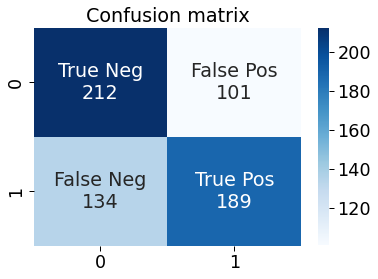

In [78]:
model(y_test, y_pred)

<Figure size 432x288 with 0 Axes>

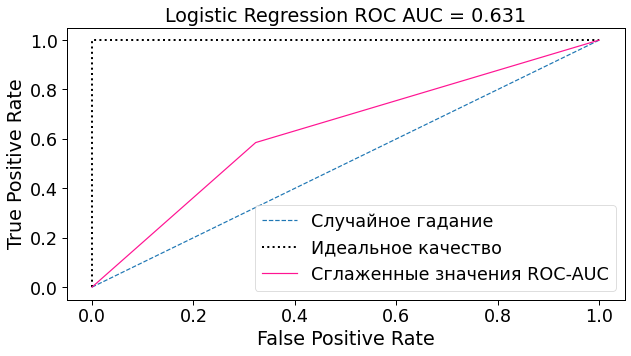

In [79]:
roc(y_test, y_pred)

$\blacktriangleright$  **Метод  k  ближайших соседей.**

In [80]:
error = [] 
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i) 
    knn.fit(x_train, y_train) 
    pred_i = knn.predict(x_test) 
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

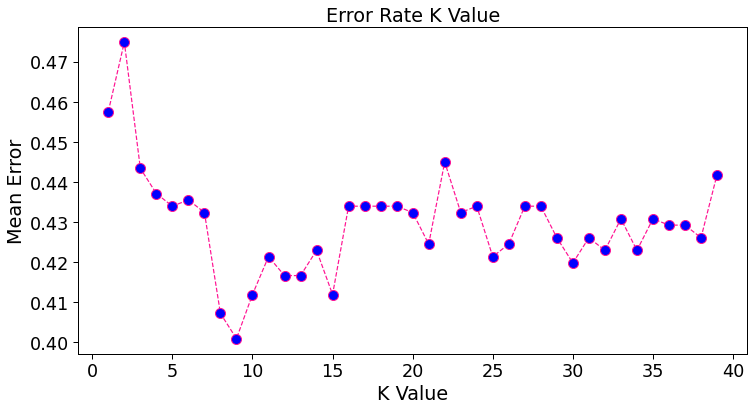

In [81]:
plt.figure(figsize=(12, 6)) 
plt.plot(range(1, 40), error, color='deeppink', linestyle='dashed', 
    marker='o', markerfacecolor='blue', markersize=10) 
plt.title('Error Rate K Value') 
plt.xlabel('K Value') 
plt.ylabel('Mean Error')

In [82]:
classif = KNeighborsClassifier(n_neighbors = 9)
classif.fit(x_train, y_train)
y_pred_knn = classif.predict(x_test)

In [83]:
val(y_test, y_pred_knn)

,Показатель,Значение
0,accuracy_score,0.60
1,recall_score,0.56
2,precision_score,0.61
3,f1_score,0.59


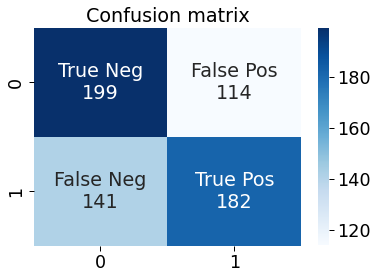

In [84]:
model(y_test, y_pred_knn)

<Figure size 432x288 with 0 Axes>

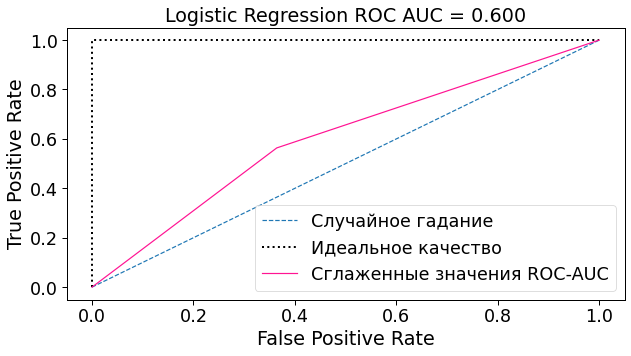

In [85]:
roc(y_test, y_pred_knn)

$\blacktriangleright$ **Бернулли Наивный Байес**

In [86]:
classif_NB = BernoulliNB()
#Обучение модели Наивного Байеса
classif_NB.fit(x_train, y_train)
 #Проверка модели на тестовой выборке
y_pred_NB = classif_NB.predict(x_test)

In [87]:
val(y_test, y_pred_NB)

,Показатель,Значение
0,accuracy_score,0.59
1,recall_score,0.42
2,precision_score,0.65
3,f1_score,0.51


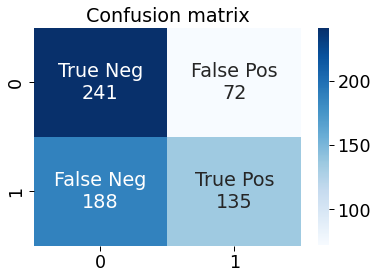

In [88]:
model(y_test, y_pred_NB)

<Figure size 432x288 with 0 Axes>

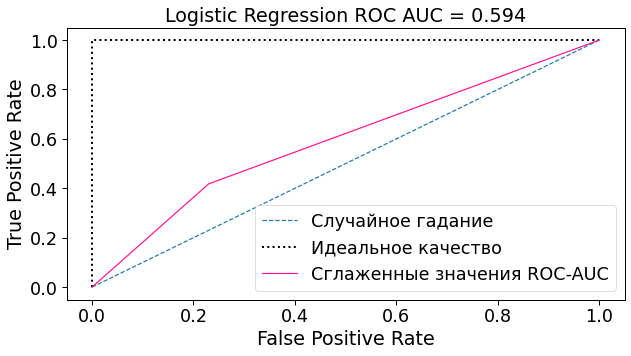

In [89]:
roc(y_test, y_pred_NB)

$\blacktriangleright$ **Gaussian Наивный Байес**

In [90]:
classif3 = GaussianNB()
#Обучение модели Наивного Байеса
classif3.fit(x_train, y_train)
#Проверка модели на тестовой выборке
y_pred3 = classif3.predict(x_test)

In [91]:
val(y_test, y_pred3)

,Показатель,Значение
0,accuracy_score,0.60
1,recall_score,0.46
2,precision_score,0.66
3,f1_score,0.54


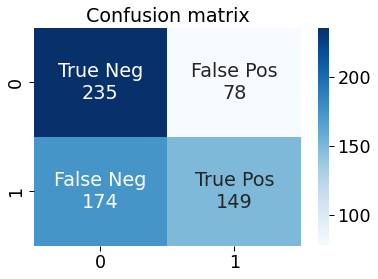

In [92]:
model(y_test, y_pred3)

<Figure size 432x288 with 0 Axes>

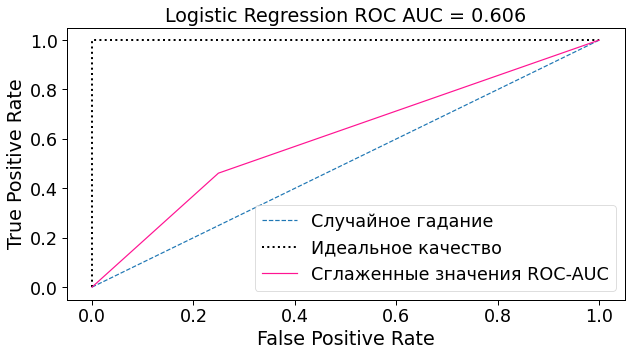

In [93]:
roc(y_test, y_pred3)

$\blacktriangleright$  **Дерево решений.**

In [94]:
#построение дерева решений с указанием параметров. (критерий разбиения, минимальное количество примеров для разбиения узлов, образования листьев)
classif_tree = DecisionTreeClassifier(min_samples_leaf=5, min_samples_split=5, criterion='gini', max_depth=4)
#обучение дерева решений   
classif_tree.fit(x_train,  y_train)
#проверка на тестовой выборке
y_pred_tree = classif_tree.predict(x_test)

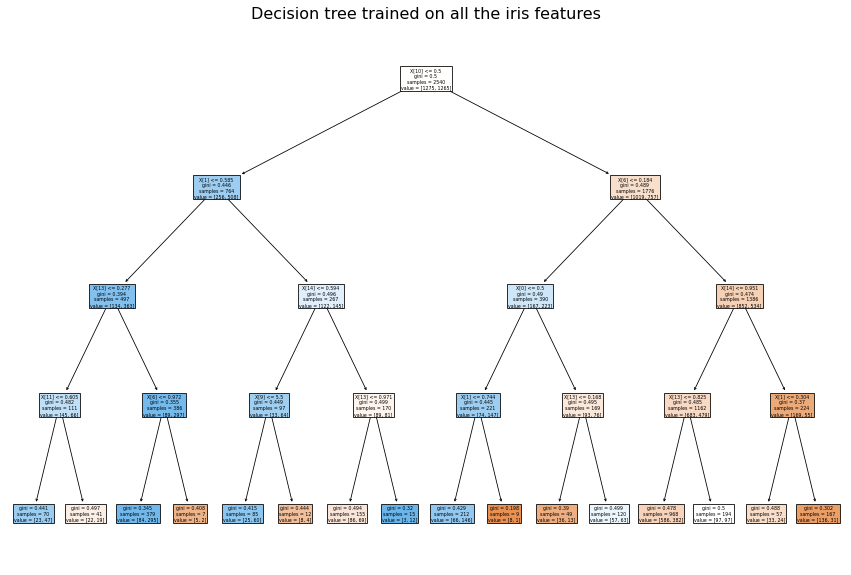

In [95]:
plt.figure(figsize=(15, 10))
plot_tree(classif_tree, filled=True)
plt.title("Decision tree trained on all the iris features", fontsize=16)
plt.show()

In [96]:
val(y_test, y_pred_tree)

,Показатель,Значение
0,accuracy_score,0.58
1,recall_score,0.45
2,precision_score,0.63
3,f1_score,0.52


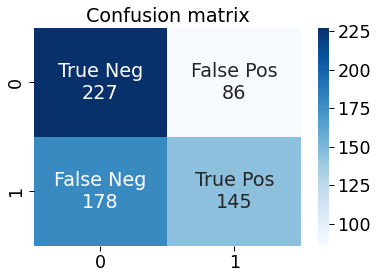

In [97]:
model(y_test, y_pred_tree)

<Figure size 432x288 with 0 Axes>

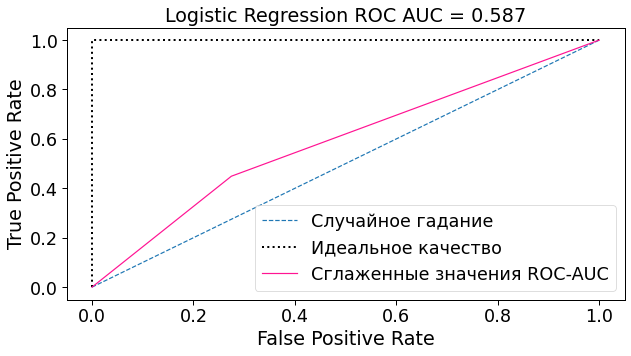

In [98]:
roc(y_test, y_pred_tree)

$\blacktriangleright$  **Случайный лес**

In [99]:
classif_sl = RandomForestClassifier(criterion='gini',
                                            max_depth=7,
                                            min_samples_split=6,
                                            min_samples_leaf=6,
                                            max_features='auto',
                                            random_state = 3)
classif_sl.fit(x_train,  y_train)
#проверка на тестовой выборке
y_pred_sl = classif_sl.predict(x_test)

In [100]:
val(y_test, y_pred_sl)

,Показатель,Значение
0,accuracy_score,0.61
1,recall_score,0.55
2,precision_score,0.63
3,f1_score,0.59


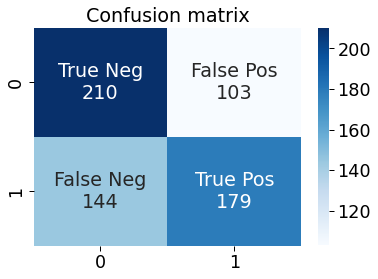

In [101]:
model(y_test, y_pred_sl)

<Figure size 432x288 with 0 Axes>

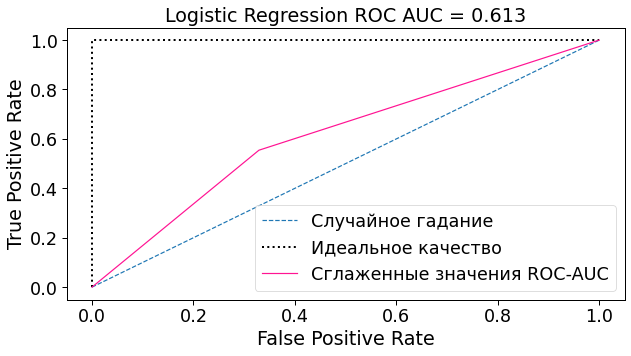

In [102]:
roc(y_test, y_pred_sl)

$\blacktriangleright$  **Сравнение моделей**

In [104]:
a_s_log = accuracy_score(y_test, y_pred).round(2)
a_s_knn = accuracy_score(y_test, y_pred_knn).round(2)
a_s_NB = accuracy_score(y_test, y_pred_NB).round(2)
a_s_3 = accuracy_score(y_test, y_pred3).round(2)
a_s_tree = accuracy_score(y_test, y_pred_tree).round(2)
a_s_sl = accuracy_score(y_test, y_pred_sl).round(2)

all_models = pd.DataFrame({
    "Mодель" : ["Логистическая регрессия", "Метод  k  ближайших соседей", "Бернулли Наивный Байес", "Gaussian Наивный Байес", "Дерево решений","Случайный лес"],
    "Точность модели (ACC)" : [a_s_log, a_s_knn, a_s_NB, a_s_3, a_s_tree, a_s_sl]
})
all_models.sort_values(by = "Точность модели (ACC)", ascending = False)

,Mодель,Точность модели (ACC)
0,Логистическая регрессия,0.63
5,Случайный лес,0.61
1,Метод k ближайших соседей,0.60
3,Gaussian Наивный Байес,0.60
2,Бернулли Наивный Байес,0.59
4,Дерево решений,0.58
